# Analyzing borrower risk of defaulting

**Objective**

The bank's loan division is seeking to build an internal credit scoring system. This ***credit scoring*** is intended to evaluate a potential customer's ability to repay a loan. The bank has provided existing data on previous customer's credit worthiness. We will analyze this data to determine which factors are likely to impact a customer's chance of defaulting on a loan. This report will be used to more accurately assess future customers' credit worthiness in order to reduce the overall default rate on loans. 

We have been tasked with specifically answering the following questions:
 - Is there a connection between having kids and repaying a loan on time?
 - Is there a connection between marital status and repaying a loan on time?
 - Is there a connection between income level and repaying a loan on time?
 - How do different loan purposes affect on-time loan repayment?

## Description of data

**`credit_scoring_eng.csv`**: 
- `children`: the number of children in the family
- `days_employed`: how long the customer has been working
- `dob_years`: the customer’s age
- `education`: the customer’s education level
- `education_id`: identifier for the customer’s education
- `family_status`: the customer’s marital status
- `family_status_id`: identifier for the customer’s marital status
- `gender`: the customer’s gender
- `income_type`: the customer’s income type
- `debt`: whether the customer has ever defaulted on a loan
- `total_income`: monthly income
- `purpose`: reason for taking out a loan

<a class='anchor' id = 'toc'></a>
## Table of contents

* 1. [Prepare notebook](#prep_nb)
* 2. [General exploration of the data](#gen_explore)
* 3. [Data pre-processing](#preprocess)
    * 3.1 [Process missing values](#missing)
        * 3.1.1 [Missing values in `'children'`](#mv_children)
        * 3.1.2 [Missing values in `'days_employed'`](#mv_de)
        * 3.1.3 [Missing values in `'age'`](#mv_age)
        * 3.1.4 [Missing values in `'total_income'`](#mv_income)
    * 3.2 [Processing duplicates](#dupes)
    * 3.3 [Categorizing data](#categorize)
        * 3.3.1 [Categorize by income](#cat_income)
        * 3.3.2 [Categorize by purpose](#cat_purpose)
    * 3.4 [Data type replacement](#dtype)
* 4. [Answer target questions](#answer_qs)
* 5. [General conclusion](#conclusion)


<a class='anchor' id = 'prep_nb'></a>
## 1. Prepare notebook

**Import libraries**

In [1]:
import pandas as pd
import numpy as np
import sidetable as stb
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from collections import Counter
import warnings

**Filter out warnings**

In [2]:
warnings.filterwarnings('ignore')

**Read file & save as dataframe**

In [3]:
# Adjust filepath as needed
file_path = 'credit_scoring_eng.csv'
credit_scoring = pd.read_csv(file_path)

[Return to Table of Contents](#toc)

<a class='anchor' id = 'gen_explore'></a>
## 2. General exploration of the data

**Overview of the full dataset**

In [4]:
# Display the first 10 rows
credit_scoring.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,bachelor's degree,0,married,0,F,employee,0,40620.102,purchase of the house
1,1,-4024.803754,36,secondary education,1,married,0,F,employee,0,17932.802,car purchase
2,0,-5623.422610,33,Secondary Education,1,married,0,M,employee,0,23341.752,purchase of the house
3,3,-4124.747207,32,secondary education,1,married,0,M,employee,0,42820.568,supplementary education
4,0,340266.072047,53,secondary education,1,civil partnership,1,F,retiree,0,25378.572,to have a wedding
5,0,-926.185831,27,bachelor's degree,0,civil partnership,1,M,business,0,40922.170,purchase of the house
6,0,-2879.202052,43,bachelor's degree,0,married,0,F,business,0,38484.156,housing transactions
7,0,-152.779569,50,SECONDARY EDUCATION,1,married,0,M,employee,0,21731.829,education
8,2,-6929.865299,35,BACHELOR'S DEGREE,0,civil partnership,1,F,employee,0,15337.093,having a wedding
9,0,-2188.756445,41,secondary education,1,married,0,M,employee,0,23108.150,purchase of the house for my family


In [5]:
credit_scoring.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 8.2 MB


* Convert days_employed to integer
* Convert education to category
* Convert family_status to category
* Convert income_type to category
* Null values present in days_employed & total_income

In [6]:
credit_scoring.describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,21525.000000,19351.000000,21525.000000,21525.000000,21525.000000,21525.000000,19351.000000
mean,0.538908,63046.497661,43.293380,0.817236,0.972544,0.080883,26787.568355
std,1.381587,140827.311974,12.574584,0.548138,1.420324,0.272661,16475.450632
min,-1.000000,-18388.949901,0.000000,0.000000,0.000000,0.000000,3306.762000
25%,0.000000,-2747.423625,33.000000,1.000000,0.000000,0.000000,16488.504500
50%,0.000000,-1203.369529,42.000000,1.000000,0.000000,0.000000,23202.870000
75%,1.000000,-291.095954,53.000000,1.000000,1.000000,0.000000,32549.611000
max,20.000000,401755.400475,75.000000,4.000000,4.000000,1.000000,362496.645000


* The 'children' column contains negative values & unusually high values.
* Most values in 'days_employed' are negative.
* The minimum value in 'dob_years' is 0.

In [7]:
# Count of null values per column
credit_scoring.stb.missing()

,missing,total,percent
days_employed,2174,21525,10.099884
total_income,2174,21525,10.099884
children,0,21525,0.000000
dob_years,0,21525,0.000000
education,0,21525,0.000000
education_id,0,21525,0.000000
family_status,0,21525,0.000000
family_status_id,0,21525,0.000000
gender,0,21525,0.000000
income_type,0,21525,0.000000


* Equal number of nulls in days_employed & total_income. Check to see if they correspond to each other.

**Education**

In [8]:
credit_scoring['education'].value_counts()

secondary education    13750
bachelor's degree       4718
SECONDARY EDUCATION      772
Secondary Education      711
some college             668
BACHELOR'S DEGREE        274
Bachelor's Degree        268
primary education        250
Some College              47
SOME COLLEGE              29
PRIMARY EDUCATION         17
Primary Education         15
graduate degree            4
Graduate Degree            1
GRADUATE DEGREE            1
Name: education, dtype: int64

* Multiple duplicates for each category caused by differences in case.

In [9]:
# Check that duplicates all match to the correct education_id
credit_scoring.groupby(['education_id','education'])['education'].count()

education_id  education          
0             BACHELOR'S DEGREE        274
              Bachelor's Degree        268
              bachelor's degree       4718
1             SECONDARY EDUCATION      772
              Secondary Education      711
              secondary education    13750
2             SOME COLLEGE              29
              Some College              47
              some college             668
3             PRIMARY EDUCATION         17
              Primary Education         15
              primary education        250
4             GRADUATE DEGREE            1
              Graduate Degree            1
              graduate degree            4
Name: education, dtype: int64

* All duplicated education values correspond to the correct education_id.

**Family Status**

In [10]:
credit_scoring.groupby(['family_status_id','family_status'])['family_status'].count()

family_status_id  family_status    
0                 married              12380
1                 civil partnership     4177
2                 widow / widower        960
3                 divorced              1195
4                 unmarried             2813
Name: family_status, dtype: int64

In [11]:
credit_scoring.stb.freq(['family_status'])

,family_status,count,percent,cumulative_count,cumulative_percent
0,married,12380,57.514518,12380,57.514518
1,civil partnership,4177,19.405343,16557,76.919861
2,unmarried,2813,13.068525,19370,89.988386
3,divorced,1195,5.551684,20565,95.540070
4,widow / widower,960,4.459930,21525,100.000000


* There are no issues with family_status or the corresponding id.
* The majority of customers are married.

**Income type**

In [12]:
credit_scoring.stb.freq(['income_type'])

,income_type,count,percent,cumulative_count,cumulative_percent
0,employee,11119,51.656214,11119,51.656214
1,business,5085,23.623693,16204,75.279907
2,retiree,3856,17.914053,20060,93.193961
3,civil servant,1459,6.778165,21519,99.972125
4,unemployed,2,0.009292,21521,99.981417
5,entrepreneur,2,0.009292,21523,99.990708
6,student,1,0.004646,21524,99.995354
7,paternity / maternity leave,1,0.004646,21525,100.000000


* There is not enough data for 'unemployed', 'enterpreneur', 'student', & 'paternity / maternity leave' to run analysis on these categories.
* The majority of  customers are listed as 'employee'.

**Gender**

In [13]:
credit_scoring['gender'].value_counts()

F      14236
M       7288
XNA        1
Name: gender, dtype: int64

In [14]:
credit_scoring[credit_scoring['gender'] == 'XNA']

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
10701,0,-2358.600502,24,some college,2,civil partnership,1,XNA,business,0,32624.825,buy real estate


* The set contains significantly more data on women than men.
* There is one unusual value 'XNA'.

**Purpose**

In [15]:
print("Number of unique values in 'purpose':", credit_scoring['purpose'].nunique())

Number of unique values in 'purpose': 38


In [16]:
credit_scoring.stb.freq(['purpose'])

,purpose,count,percent,cumulative_count,cumulative_percent
0,wedding ceremony,797,3.702671,797,3.702671
1,having a wedding,777,3.609756,1574,7.312427
2,to have a wedding,774,3.595819,2348,10.908246
3,real estate transactions,676,3.140534,3024,14.048780
4,buy commercial real estate,664,3.084785,3688,17.133566
5,housing transactions,653,3.033682,4341,20.167247
6,buying property for renting out,653,3.033682,4994,23.200929
7,transactions with commercial real estate,651,3.024390,5645,26.225319
8,purchase of the house,647,3.005807,6292,29.231127
9,housing,647,3.005807,6939,32.236934


### Notes on general exploration

<b>Data Types</b>

- The 'days_employed' column should be converted to int type. There are an equal number of nulls in 'total_income'and 'days_employed'.
- Education, family_status, gender, & income_type can all be converted to category type to reduce memory usage.  
    
<b>Missing values</b>
    
- There are null values in the 'days_employed' and 'total_income' columns.
- The maximum number of children is 20 and the minimum is -1, so this column will need to be explored.
- The minimum age ('dob_years') is 0, so these should be explored as missing values. 
- The days_employed column has a lot of negative values and is generally a mess.
- There is one value "XNA" in the 'gender' column. This will be left alone as is. 3rd options for gender are becoming more common as a way to accommodate people who do not identify within the binary. There is no reasonable way to assume this value is missing, the rest of the row sees normal, and it does not affect our analysis.

<b>Duplicates</b>
    
- The 'education' column has duplicate values. Setting all values to uppercase should elimate these duplicates.

<b>Categorization</b>
- The 'purpose' column contains several similar values that can be simplified into categories.
- Income should be categorized by income levels for easier analysis.
    

[Return to Table of Contents](#toc)

<a class='anchor' id = 'preprocess'></a>
## 3. Data preprocessing

Address all issues addressed in the previous section, including: missing values & duplicated values. Further process the data to create income and purpose categories that will be used in later analysis.

In [17]:
# Create a copy of credit_scoring to make changes to
cs_new = credit_scoring.copy()
# Rename columns for clarity
cs_new.rename(columns = {'dob_years': 'age', 'debt': 'defaulted'}, inplace=True)

<a class='anchor' id = 'missing'></a>
### 3.1 Process missing values

<a class='anchor' id = 'mv_children'></a>
#### 3.1.1 Missing values in `'children'`

In [18]:
# All values of 'children'
cs_new.stb.freq(['children'])

,children,count,percent,cumulative_count,cumulative_percent
0,0,14149,65.732869,14149,65.732869
1,1,4818,22.383275,18967,88.116144
2,2,2055,9.547038,21022,97.663182
3,3,330,1.533101,21352,99.196283
4,20,76,0.353078,21428,99.549361
5,-1,47,0.218351,21475,99.767712
6,4,41,0.190476,21516,99.958188
7,5,9,0.041812,21525,100.000000


The values -1 & 20 both occur multiple times and are likely misprints of 1 & 2 respectively.

There are few enough rows containing these values that they will not have a large impact on aggragate values such as average income and default rate.

In [19]:
# Change all columns where children = 20 to 2.
cs_new.loc[cs_new['children']==20, 'children'] = 2
cs_new.loc[cs_new['children']==-1, 'children'] = 1

#Check the data set
cs_new.stb.freq(['children'])

,children,count,percent,cumulative_count,cumulative_percent
0,0,14149,65.732869,14149,65.732869
1,1,4865,22.601626,19014,88.334495
2,2,2131,9.900116,21145,98.234611
3,3,330,1.533101,21475,99.767712
4,4,41,0.190476,21516,99.958188
5,5,9,0.041812,21525,100.000000


<div class="alert alert-block alert-info">
<b>Notes on 'children'</b><br>

The only unusual values were -1 and 20. Columns with a value of -1 were assumed to be 1. Values of 20 were assumed to be a typo for 2, due to the proximity of the 2 and 0 buttons on a 10-key input.

</div>

[Return to Table of Contents](#toc)

<a class='anchor' id = 'mv_age'></a>
#### 3.1.3 Missing values in `'age'`

**Explore the distribition of customer ages**

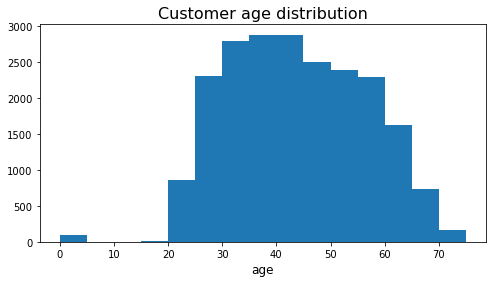

In [20]:
# Histogram of 'age' frequencies
plt.figure(figsize=(8,4));
plt.hist(cs_new['age'], bins=np.arange(0,80,5));
plt.title('Customer age distribution', size=16);
plt.xlabel('age', size=12);

* There should be no values below roughly 18, but we see a small bump at 0.
* There dont appear to be many other values below 20.
* Otherwise, the distribution appears fairly normal.

Look into values under 18 (standard minimum age for opening bank accounts, requesting loans, etc)

In [21]:
cs_new[cs_new['age']<18]['age'].value_counts()

0    101
Name: age, dtype: int64

* There are no unusual ages other than 0. These are missing ages.

In [22]:
#Slice of data where age is 0
age_zero = cs_new[cs_new['age'] == 0]
age_zero.head()

,children,days_employed,age,education,education_id,family_status,family_status_id,gender,income_type,defaulted,total_income,purpose
99,0,346541.618895,0,Secondary Education,1,married,0,F,retiree,0,11406.644,car
149,0,-2664.273168,0,secondary education,1,divorced,3,F,employee,0,11228.230,housing transactions
270,3,-1872.663186,0,secondary education,1,married,0,F,employee,0,16346.633,housing renovation
578,0,397856.565013,0,secondary education,1,married,0,F,retiree,0,15619.310,construction of own property
1040,0,-1158.029561,0,bachelor's degree,0,divorced,3,F,business,0,48639.062,to own a car


In [23]:
age_zero.describe()

,children,days_employed,age,education_id,family_status_id,defaulted,total_income
count,101.000000,91.000000,101.0,101.000000,101.000000,101.000000,91.000000
mean,0.495050,65937.471974,0.0,0.673267,1.237624,0.079208,25334.072890
std,0.807759,143332.816768,0.0,0.512033,1.524129,0.271410,11901.096532
min,0.000000,-10689.250498,0.0,0.000000,0.000000,0.000000,5595.912000
25%,0.000000,-2258.921067,0.0,0.000000,0.000000,0.000000,15933.259000
50%,0.000000,-1146.689586,0.0,1.000000,1.000000,0.000000,24387.070000
75%,1.000000,-245.276828,0.0,1.000000,3.000000,0.000000,34007.907500
max,3.000000,400992.375704,0.0,2.000000,4.000000,1.000000,61819.782000


* Missing ages don't seem to correspond to any particular groups or other missing values.

**Explore the relationship between age and different columns.**

We can fill missing age values with average ages based on other factors. We will explore the relationship to gender, income_type, and family_status.

In [24]:
# Mean age by gender
cs_new.groupby('gender')['age'].mean()

gender
F      44.471972
M      40.993825
XNA    24.000000
Name: age, dtype: float64

* There is roughly a 4 year difference in average age between genders. XNA only contains one value, and so can be ignored.

In [25]:
# Mean age based on income type
cs_new.groupby('income_type')['age'].mean()

income_type
business                       39.697542
civil servant                  40.636737
employee                       39.821027
entrepreneur                   42.500000
paternity / maternity leave    39.000000
retiree                        59.063019
student                        22.000000
unemployed                     38.000000
Name: age, dtype: float64

In [26]:
# Mean age based on gender & family status
cs_new.groupby(['family_status','gender'])['age'].mean()

family_status      gender
civil partnership  F         42.952232
                   M         40.342508
                   XNA       24.000000
divorced           F         46.215812
                   M         42.996139
married            F         44.094933
                   M         42.663250
unmarried          F         41.366628
                   M         33.567068
widow / widower    F         56.675138
                   M         53.854545
Name: age, dtype: float64

Check which income types & family statuses are present in the age_zero slice. Only relevant values will be used to fill ages.

In [27]:
print('Income types')
print(age_zero.income_type.unique())
print()
print('Family Status')
print(age_zero.family_status.unique())

Income types
['retiree' 'employee' 'business' 'civil servant']

Family Status
['married' 'divorced' 'unmarried' 'widow / widower' 'civil partnership']


* All family_status values are present.

In [28]:
#List of relevant income types
inc_types = ['business','civil servant','employee','retiree']
#Slice of cs_new only containing the above income types
cs_age_rel= cs_new[cs_new['income_type'].isin(inc_types) & cs_new['gender'].isin(['F','M'])]

In [29]:
#Pivot table of mean ages based on family_status, income_type, & gender
cs_age_rel.pivot_table(index='income_type',
                   columns=['family_status', 'gender'],
                   values='age',
                   aggfunc='mean',
                   margins=True
                  )

family_status civil partnership              divorced               married  \
gender                        F          M          F          M          F   
income_type                                                                   
business              38.681138  38.198847  43.395122  42.029851  40.224197   
civil servant         41.346154  38.240741  41.808219  39.750000  41.185471   
employee              39.239698  38.770807  42.596916  42.627219  40.248229   
retiree               59.069288  56.888889  58.681373  53.200000  58.729271   
All                   42.957083  40.342508  46.215812  42.996139  44.095586   

family_status             unmarried            widow / widower             \
gender                 M          F          M               F          M   
income_type                                                                 
business       41.155652  37.453988  32.331230       51.626374  48.333333   
civil servant  39.446154  37.855769  33.650000       52.904762  57.666667   
employee       40.495892  37.550181  32.668175       51.093750  49.458333   
retiree        59.573737  58.785256  58.425000       60.641473  59.636364   
All            42.662448  41.366628  33.577778       56.675138  53.854545   

family_status        All  
gender                    
income_type               
business       39.700629  
civil servant  40.636737  
employee       39.821027  
retiree        59.063019  
All            43.296031

In [30]:
#Pivot table of counts of the same categories as above
cs_age_rel.pivot_table(index='income_type',
                   columns=['family_status', 'gender'],
                   values='age',
                   aggfunc='count',
                   margins=True
                  )

family_status civil partnership       divorced      married       unmarried  \
gender                        F     M        F    M       F     M         F   
income_type                                                                   
business                    668   347      205   67    1744  1150       489   
civil servant               208    54       73    8     647   260       104   
employee                   1456   781      454  169    3811  2678       827   
retiree                     534   126      204   15    1592   495       312   
All                        2866  1308      936  259    7794  4583      1732   

family_status       widow / widower        All  
gender            M               F   M         
income_type                                     
business        317              91   6   5084  
civil servant    60              42   3   1459  
employee        663             256  24  11119  
retiree          40             516  22   3856  
All            1080             905  55  21518

The gender difference seems to remain present to some extent across categories. The average retiree age is largely unaffected by other factors, and should be calculated on its own. Unmarried values seem to differ from the other family_status values and are unaffected by non-retiree income types. The remaining values don't differ much overall.

Values will be filled as follows from cs_age_rel:
* Retirees will be filled with the mean retiree age
* Unmarried will be filled based on unmarried average by gender (excluding retirees)
* All remaining will be filled with the average age of all remaining non-retiree non-unmarried values

In [31]:
#Calculate average age based on whether or not the customer is a retiree
retiree_age = int(cs_age_rel[cs_age_rel['income_type']=='retiree']['age'].mean())
unmarried_slice = (cs_age_rel[(cs_age_rel['income_type']!='retiree')
                            & (cs_age_rel['family_status']=='unmarried')]
                            [['gender','age']]
                  )
other_age = int(cs_age_rel[(cs_age_rel['income_type']!='retiree')
                            & (cs_age_rel['family_status']!='unmarried')]
                            ['age'].mean()
                  )
uf_age = int(unmarried_slice[unmarried_slice['gender'] == 'M']['age'].mean())
um_age = int(unmarried_slice[unmarried_slice['gender'] == 'F']['age'].mean())

print('Retiree average age:', retiree_age)
print()
print('Unmarried averages')
print(unmarried_slice.groupby('gender')['age'].mean())
print()
print('Remaining averages:', other_age)

Retiree average age: 59

Unmarried averages
gender
F    37.539437
M    32.622115
Name: age, dtype: float64

Remaining averages: 40


In [32]:
age0 = (cs_new['age'] == 0)
retiree= (cs_new['income_type'] == 'retiree')
unmarried = (cs_new['family_status'] == 'unmarried')
male = (cs_new['gender'] == 'M')

#Replace age for retirees
cs_new.loc[age0 & retiree, 'age'] = retiree_age

#Replace age for unmarried males
cs_new.loc[age0 & unmarried & male, 'age'] = um_age

#Replace afe for unmarried females
cs_new.loc[age0 & unmarried, 'age']= uf_age

#Replace remaining ages
cs_new.loc[age0, 'age']= other_age

#Check 'age' column for 0s. Should be empty
print("Remaining 0s in age column:", len(cs_new[cs_new['age']==0]))
print('Minimum age:', cs_new.age.min())
print('Maximum age:', cs_new.age.max())

Remaining 0s in age column: 0
Minimum age: 19
Maximum age: 75


<b>Notes on 'age' </b><br>

Missing ages were represented by 0, indicating that age is an optional field. Other than that, the age distribution looks fairly normal, with a minimum age of 19 and maximum age of 75.
    
Ages were filled based on a few simplified factors: retired, unmarried split by gender, and then all remaining customers. These averages will allow is to stay somewhat close to the expected reality.
    

[Return to Table of Contents](#toc)

<a class='anchor' id = 'mv_de'></a>
#### 3.1.2 Missing values in `'days_employed'`

In [33]:
# Check for 0 values in dayes_employed
print('# of rows where days_employed is zero:', len(cs_new[cs_new['days_employed'] == 0]))

# of rows where days_employed is zero: 0


* No zero values. We would expect 0 to be the value for customers who are not currently working, however this is not the case.

In [34]:
#Create separate slices to explore based on conditions in days_employed: null, negative, positive
de_null = cs_new[cs_new['days_employed'].isnull()]
de_neg = cs_new[cs_new['days_employed'] < 0]
de_pos = cs_new[cs_new['days_employed'] > 0]

**Explore where days_employed is NULL**

In [35]:
#Check if null values in days_employed corresponds to any income types
print(de_null['income_type'].value_counts())

employee         1105
business          508
retiree           413
civil servant     147
entrepreneur        1
Name: income_type, dtype: int64


* Null values don't correspond to any employment type. These values are fully missing.

In [36]:
#Rows where days_employed is null & total_income not null
de_null[de_null['total_income'].notnull()].shape[0]

0

* The null values in days_employed and total_income correspond perfectly as suspected.

**Explore where days_employed is POSITIVE**

In [37]:
#Check if positive # of days_employed corresponds to any income types
de_pos['income_type'].value_counts()

retiree       3443
unemployed       2
Name: income_type, dtype: int64

* Positive days_employed correspond to "retiree" & "unemployed", both of which should have a days_employed value of 0.

In [38]:
#Calculate days_employed as years_employed for increased understanding of the values
de_pos['years_employed'] = de_pos['days_employed']/365.25
de_pos.describe()

,children,days_employed,age,education_id,family_status_id,defaulted,total_income,years_employed
count,3445.000000,3445.000000,3445.000000,3445.000000,3445.000000,3445.000000,3445.000000,3445.000000
mean,0.095791,365004.309916,59.322206,0.914659,0.984325,0.052830,21939.856893,999.327337
std,0.338400,21075.016396,6.478911,0.517103,1.316071,0.223727,12838.753752,57.700250
min,0.000000,328728.720605,22.000000,0.000000,0.000000,0.000000,3306.762000,900.010186
25%,0.000000,346639.413916,56.000000,1.000000,0.000000,0.000000,13260.214000,949.046992
50%,0.000000,365213.306266,60.000000,1.000000,0.000000,0.000000,18962.318000,999.899538
75%,0.000000,383246.444219,64.000000,1.000000,2.000000,0.000000,27159.402000,1049.271579
max,4.000000,401755.400475,74.000000,4.000000,4.000000,1.000000,117616.523000,1099.946339


* The minimum number of years employeed is 900, with a max of 1100. These seem to be arbitrarily large numbers.

**Explore where days_employed is NEGATIVE**

In [39]:
#Check if negative days_employed corresponds to any income types
de_neg['income_type'].value_counts()

employee                       10014
business                        4577
civil servant                   1312
student                            1
entrepreneur                       1
paternity / maternity leave        1
Name: income_type, dtype: int64

* Retiree & unemployed are missing from negative days employed.

In [40]:
#Calculate days_employed as years_employed for increased understanding of the values
de_neg['years_employed'] = de_neg['days_employed']/365.25
de_neg.describe()

,children,days_employed,age,education_id,family_status_id,defaulted,total_income,years_employed
count,15906.000000,15906.000000,15906.000000,15906.000000,15906.000000,15906.000000,15906.000000,15906.000000
mean,0.562744,-2353.015932,40.004338,0.798378,0.969634,0.087326,27837.509634,-6.442207
std,0.792367,2304.243851,10.309803,0.554845,1.442263,0.282320,16980.846677,6.308676
min,0.000000,-18388.949901,19.000000,0.000000,0.000000,0.000000,3418.824000,-50.346201
25%,0.000000,-3157.480084,32.000000,0.000000,0.000000,0.000000,17323.415000,-8.644709
50%,0.000000,-1630.019381,39.000000,1.000000,0.000000,0.000000,24181.535000,-4.462750
75%,1.000000,-756.371964,48.000000,1.000000,1.000000,0.000000,33839.106500,-2.070834
max,5.000000,-24.141633,75.000000,4.000000,4.000000,1.000000,362496.645000,-0.066096


The absolute values of the negative values in "years_employed" look much more realistic as actual lengths of employement. We will assume the absolute values of these negatives are the true values. Previously positive values will be set to 0 to represent lack of employment.

In [41]:
#Change positives to 0 to represent unemployment
cs_new.loc[cs_new['days_employed'] > 0, 'days_employed'] = 0

#Change negatives to positives
cs_new['days_employed'] = cs_new['days_employed'].abs()

cs_new.describe()

,children,days_employed,age,education_id,family_status_id,defaulted,total_income
count,21525.000000,19351.000000,21525.000000,21525.000000,21525.000000,21525.000000,19351.000000
mean,0.479721,1934.115623,43.481069,0.817236,0.972544,0.080883,26787.568355
std,0.755528,2274.751213,12.220504,0.548138,1.420324,0.272661,16475.450632
min,0.000000,0.000000,19.000000,0.000000,0.000000,0.000000,3306.762000
25%,0.000000,291.095954,34.000000,1.000000,0.000000,0.000000,16488.504500
50%,0.000000,1203.369529,42.000000,1.000000,0.000000,0.000000,23202.870000
75%,1.000000,2747.423625,53.000000,1.000000,1.000000,0.000000,32549.611000
max,5.000000,18388.949901,75.000000,4.000000,4.000000,1.000000,362496.645000


To be sure that the new length of employement is reasonable, we should compare days_employed to customer age. First, days_employed must be converted to years to ease comparison.

In [42]:
#Create column years_employed
cs_new['years_employed'] = (cs_new['days_employed']/365.25).round(1)

#Create a slice of just age and years_employed
age_yemp = cs_new[['age','years_employed']]
age_yemp.describe()

,age,years_employed
count,21525.000000,19351.000000
mean,43.481069,5.295401
std,12.220504,6.228109
min,19.000000,0.000000
25%,34.000000,0.800000
50%,42.000000,3.300000
75%,53.000000,7.500000
max,75.000000,50.300000


In [43]:
#Check highest values of years_employed compared to age
age_yemp.sort_values('years_employed', ascending = False).head(10)

,age,years_employed
16335,61,50.3
4299,61,48.2
7329,60,45.4
17838,59,44.5
16825,64,44.1
3974,64,43.4
4321,61,43.2
1539,59,43.2
7731,64,42.8
15675,65,42.2


Most of these values seem reasonable, while others are unlikely. For example, the highest value implies this person started working at 11 years old. All values that imply a customer started working under the age of 15 will be assumed missing.

In [44]:
#Check for values of years_employed that don't match working age of 15
cond_age15 = (cs_new['age'] - cs_new['years_employed']) < 15

print("The number of rows that don't meet a minimum working age of 15:",len(cs_new[cond_age15]))

cs_new[cond_age15].head(10)

The number of rows that don't meet a minimum working age of 15: 45


,children,days_employed,age,education,education_id,family_status,family_status_id,gender,income_type,defaulted,total_income,purpose,years_employed
397,0,12506.318296,46,secondary education,1,married,0,F,employee,0,46854.926,property,34.2
714,1,7375.209318,35,secondary education,1,married,0,M,civil servant,0,42786.456,housing transactions,20.2
2082,0,10689.250498,40,secondary education,1,married,0,F,employee,0,61819.782,real estate transactions,29.3
2492,0,13724.223884,50,bachelor's degree,0,married,0,F,employee,0,14104.366,building a real estate,37.6
3417,1,5673.867214,29,secondary education,1,married,0,M,employee,0,46084.516,to get a supplementary education,15.5
3645,1,8602.090178,38,bachelor's degree,0,civil partnership,1,M,employee,0,29586.384,housing renovation,23.6
3957,0,12111.680981,47,secondary education,1,married,0,F,business,0,17344.981,buy commercial real estate,33.2
4299,0,17615.563266,61,secondary education,1,married,0,F,business,0,19609.719,purchase of the house,48.2
5230,1,8719.808251,38,secondary education,1,civil partnership,1,F,employee,0,11679.853,property,23.9
5581,0,15079.216069,55,secondary education,1,married,0,F,civil servant,0,28601.820,housing transactions,41.3


In [45]:
#Set unrealistic values of days employed & days_employed to 0
cs_new.loc[cond_age15, 'days_employed'] = 0

<b>Notes on 'days_employed'</b><br>
    
Analyzing this column based on positive, negative, and null values allowed a lot of insight. Positive values corresponded to non-work income types (unemployed, retiree) and were unrealistically large. Negative values corresponded with working income types. Most of the absolute value of these negatives gave very realistic ranges of days_employed. The best guess is to set the positive values to 0 to represent a lack of work, and replace negative values with their absolute values.<br>
    
After these changes, we had some unrealistically high values of days_worked. Any value of days_worked that would have started before the customer was 15 years of age was replaced with 0. Since we will not be analyzing based on this column, this will not affect our analysis.<br>
    
Ultimately the developer should be contacted an informed of these problems. It may help give them insight into what the problem is. Null values were not correlated with any income types, but directly corresponded to null values in total_income. These seem to just be completely missing.


[Return to Table of Contents](#toc)

<a class='anchor' id = 'mv_income'></a>
#### 3.1.4 Missing values in `'total_income'`

We already know null in values do not correspond to income types, since they did not correspond to the same rows with null days_employes.

These rows should be dropped, since they will impact our overall analysis.

In [46]:
# Count & percentage of missing values
cs_new.stb.missing(['total_income'])

,missing,total,percent
days_employed,2174,21525,10.099884
total_income,2174,21525,10.099884
years_employed,2174,21525,10.099884


* Just over 10% of values are missing. These should be dropped.

In [47]:
#Drop rows where 'total_income' is null
cs_new = cs_new.dropna(subset = ['total_income']).reset_index(drop=True)

<b>Notes on 'total_income'</b><br>
    
The missing values in total_income do not correspond with any particular income_type, and so they appear to be missing completely at random. This column significantly affects our analysis, and there is not much information to help fill these values. The range of total_income is very diverse, so filling this value with an average value without any career information will be incredibly inaccurate. The nulls account for 10.1% of the total data, which is small enough to safely drop.
    

[Return to Table of Contents](#toc)

### Conclusions on  missing values

Missing values were identified in the following columns: children, age, days_worked, total_income. For the purposes of our analysis, 'children' and 'total_income' are the only columns of significance.

<br>There were very few missing values in the 'children' column. These values were assumed to be typos and were converted to the most likely values.
    
<br>The missing values in 'total_income' presented a larger problem. They accounted for a somewhat significant though manageable portion of the data. The direct correspondence with the missing values in 'days_worked' implies these are somehow linked. The only way to know whether they were optional fields or were somehow lost in the export process would be to ask the source of the data.
    
<br>The missing values in the age column were simply filled with appropriate averages. While these do not directly affect our analysis, filling these values will allow for a deeper, suplemental understanding of our data in our final analysis.


[Return to Table of Contents](#toc)

<a class='anchor' id = 'dupes'></a>
### 3.2 Processing duplicates

**Fix duplicate values in 'education'**

In [48]:
#Set all education values to lower case
cs_new['education'] = cs_new['education'].str.lower()

#Check for remaining duplicates
cs_new.groupby(['education_id','education'])['education'].count()

education_id  education          
0             bachelor's degree       4716
1             secondary education    13693
2             some college             675
3             primary education        261
4             graduate degree            6
Name: education, dtype: int64

**Check for fully duplicated rows**

In [49]:
#Check for duplicates where 'total_income' is not null
print('Duplicated rows:',cs_new[cs_new['total_income'].notnull()].duplicated().sum())

Duplicated rows: 0


<b>Notes on duplicates</b>
    
All duplicates in the 'education' column were caused by differences in capitalization. Converting all the values to lower case eradicated all duplicates. As suspected, only rows with null values in both 'total_income' and 'days_employed' showed duplicates. However, the rest of the customer information is generic. There is no way to know if these are true duplicates without a customer ID. This confirms the previous decision to drop the rows with null values in those columns to help avoid false duplicates.   


[Return to Table of Contents](#toc)

<a class='anchor' id = 'categorize'></a>
### 3.3 Categorizing data

<a class='anchor' id = 'cat_income'></a>
#### 3.3.1 Categorize by income

Assign each customer an income category for easier analysis.

In [50]:
cs_new.describe()

,children,days_employed,age,education_id,family_status_id,defaulted,total_income,years_employed
count,19351.000000,19351.000000,19351.000000,19351.000000,19351.000000,19351.000000,19351.000000,19351.000000
mean,0.479613,1909.542324,43.443440,0.819079,0.972249,0.081184,26787.568355,5.295401
std,0.753895,2231.389671,12.225009,0.550104,1.420596,0.273125,16475.450632,6.228109
min,0.000000,0.000000,19.000000,0.000000,0.000000,0.000000,3306.762000,0.000000
25%,0.000000,282.957994,33.000000,1.000000,0.000000,0.000000,16488.504500,0.800000
50%,0.000000,1195.621516,42.000000,1.000000,0.000000,0.000000,23202.870000,3.300000
75%,1.000000,2727.057054,53.000000,1.000000,1.000000,0.000000,32549.611000,7.500000
max,5.000000,16119.687737,75.000000,4.000000,4.000000,1.000000,362496.645000,50.300000


* Income increases drastically between the 75th percentile and the max value, suggesting there are outliers. Lets take a slice up to 100k to gt an idea of the distribution.

In [51]:
under_100k = cs_new[cs_new['total_income'] <=100000]

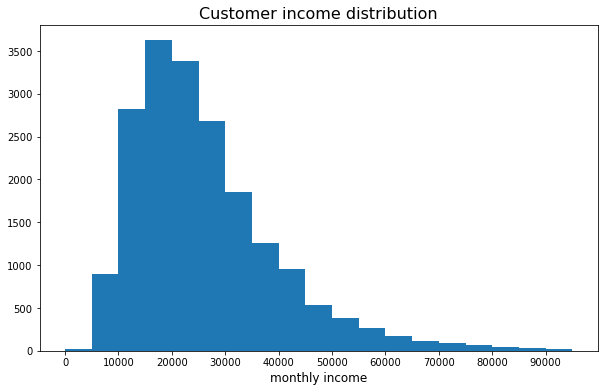

In [52]:
# Histogram of 'age' frequencies
plt.figure(figsize=(10,6));
plt.hist(under_100k.total_income, bins = np.arange(0,100000,5000));
plt.title('Customer income distribution', size=16);
plt.xlabel('monthly income', size=12);
plt.xticks(np.arange(0,100000,10000));

* There is a drastic increase from 10k to 20k.
* Somewhat steady decline after 20k
* Skewed to the right as expected
* Income levels will be set at steps of 10k, with 40k+ being considered very high

In [53]:
#Create method that returns an income level based on total income
def income_bracket(data):
    income = data['total_income']    
    if income <= 10000:
        return 'very low'
    if 10000 < income <= 20000:
        return 'low'
    if 20000 < income <= 30000:
        return 'medium'
    if 30000 < income <= 40000:
        return 'high'
    if income > 40000:
        return 'very high'

#Apply income_bracket to create a new income_level column
cs_new['income_level'] = cs_new.apply(income_bracket, axis = 1)
#Check the income_level column
print(cs_new['income_level'].value_counts())

low          6443
medium       6063
high         3107
very high    2812
very low      926
Name: income_level, dtype: int64


[Return to Table of Contents](#toc)

<a class='anchor' id = 'cat_purpose'></a>
#### 3.3.2 Categorize by purpose

Simplify values in the "purpose" column by grouping similar purposes into categories.

In [54]:
#Explore the values in 'purpose'
cs_new['purpose'].value_counts()

wedding ceremony                            721
to have a wedding                           693
having a wedding                            685
real estate transactions                    615
buy commercial real estate                  597
purchase of the house                       595
buying property for renting out             588
housing                                     587
transactions with commercial real estate    581
building a real estate                      580
housing transactions                        579
purchase of my own house                    574
property                                    572
purchase of the house for my family         570
building a property                         561
construction of own property                560
transactions with my real estate            559
buy real estate                             552
buy residential real estate                 546
housing renovation                          542
car                                     

* There are obvious recurring purposes with slightly different descriptions.
* There are many words with similar stems that should be categorized together.

In [55]:
#Create list purpose_categories to store all unique values of purpose
purpose_categories = cs_new['purpose'].unique()
#Combine all word in the list
purpose_joined = ' '.join(row for row in purpose_categories)
print(purpose_joined)

purchase of the house car purchase supplementary education to have a wedding housing transactions education having a wedding purchase of the house for my family buy real estate buy commercial real estate buy residential real estate construction of own property property building a property buying a second-hand car buying my own car transactions with commercial real estate housing transactions with my real estate cars to become educated getting an education second-hand car purchase car wedding ceremony to get a supplementary education purchase of my own house real estate transactions getting higher education to own a car purchase of a car profile education university education buying property for renting out to buy a car building a real estate housing renovation going to university


In [56]:
#Declare stemmer
english_stemmer = SnowballStemmer('english')
#Declare empty list to hold stems
stems = []
#Stem each word that appears in all 'purpose' categories
for word in  purpose_joined.split(' '):
    stems.append(english_stemmer.stem(word))
#Use counter to see all stems and get an idea of frequency
Counter(stems)

Counter({'purchas': 6,
         'of': 5,
         'the': 2,
         'hous': 6,
         'car': 9,
         'supplementari': 2,
         'educ': 8,
         'to': 6,
         'have': 2,
         'a': 9,
         'wed': 3,
         'transact': 4,
         'for': 2,
         'my': 4,
         'famili': 1,
         'buy': 7,
         'real': 7,
         'estat': 7,
         'commerci': 2,
         'residenti': 1,
         'construct': 1,
         'own': 4,
         'properti': 4,
         'build': 2,
         'second-hand': 2,
         'with': 2,
         'becom': 1,
         'get': 3,
         'an': 1,
         'ceremoni': 1,
         'higher': 1,
         'profil': 1,
         'univers': 2,
         'rent': 1,
         'out': 1,
         'renov': 1,
         'go': 1})

The following groups have been identified from these stems:
* vehicle: 'car'
* wedding: 'wed'
* education: 'educ' & 'univers'
* housing & real estate: 'estat', 'hous', 'properti'

In [57]:
#Create lists to combine multiple stems that fit under the same category
housing = ['estat', 'hous', 'properti']
edu = ['educ', 'univers']

#Define function returning categories based on stems in 'purpose'
def categorize_purpose(text):
    words = text.split(" ")
    for word in words:
        stem = english_stemmer.stem(word)
        if stem == 'car':
            return 'vehicle'
        elif stem == 'wed':
            return 'wedding'
        elif stem in edu:
            return 'education'
        elif stem in housing:
            return 'housing & real estate'

#Apply categorize_purpose to the 'purpose' category to create a new column
cs_new['purpose_category'] = cs_new['purpose'].apply(categorize_purpose)
#Check it out
cs_new.head(10)

,children,days_employed,age,education,education_id,family_status,family_status_id,gender,income_type,defaulted,total_income,purpose,years_employed,income_level,purpose_category
0,1,8437.673028,42,bachelor's degree,0,married,0,F,employee,0,40620.102,purchase of the house,23.1,very high,housing & real estate
1,1,4024.803754,36,secondary education,1,married,0,F,employee,0,17932.802,car purchase,11.0,low,vehicle
2,0,5623.422610,33,secondary education,1,married,0,M,employee,0,23341.752,purchase of the house,15.4,medium,housing & real estate
3,3,4124.747207,32,secondary education,1,married,0,M,employee,0,42820.568,supplementary education,11.3,very high,education
4,0,0.000000,53,secondary education,1,civil partnership,1,F,retiree,0,25378.572,to have a wedding,0.0,medium,wedding
5,0,926.185831,27,bachelor's degree,0,civil partnership,1,M,business,0,40922.170,purchase of the house,2.5,very high,housing & real estate
6,0,2879.202052,43,bachelor's degree,0,married,0,F,business,0,38484.156,housing transactions,7.9,high,housing & real estate
7,0,152.779569,50,secondary education,1,married,0,M,employee,0,21731.829,education,0.4,medium,education
8,2,6929.865299,35,bachelor's degree,0,civil partnership,1,F,employee,0,15337.093,having a wedding,19.0,low,wedding
9,0,2188.756445,41,secondary education,1,married,0,M,employee,0,23108.150,purchase of the house for my family,6.0,medium,housing & real estate


In [58]:
#Search for remaining nulls in purpose_category
print('Remanining nulls:', len(cs_new[cs_new['purpose_category'].isnull()]))

Remanining nulls: 0


<b>Categorization notes</b>

New columns were created for income_level and purpose_category. After investigating the distribution of incomes, 'income_level' was categorized into 5 levels at intervals of 10,000. The 'purpose' column was sorted into 4 major categorys: vehicle, wedding, education, and housing & real estate.


[Return to Table of Contents](#toc)

<a class='anchor' id = 'dtype'></a>

### 3.4 Data type replacement

In [59]:
category_columns = ['purpose_category','family_status','income_type','income_level']
cs_new['days_employed'] = cs_new['days_employed'].astype('int')
cs_new[category_columns] = cs_new[category_columns].astype('category')
# Drop years_employed and the old purpose column
cs_new.drop(columns=['years_employed','purpose'], inplace=True)
#Check it
cs_new.info(memory_usage ='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19351 entries, 0 to 19350
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   children          19351 non-null  int64   
 1   days_employed     19351 non-null  int64   
 2   age               19351 non-null  int64   
 3   education         19351 non-null  object  
 4   education_id      19351 non-null  int64   
 5   family_status     19351 non-null  category
 6   family_status_id  19351 non-null  int64   
 7   gender            19351 non-null  object  
 8   income_type       19351 non-null  category
 9   defaulted         19351 non-null  int64   
 10  total_income      19351 non-null  float64 
 11  income_level      19351 non-null  category
 12  purpose_category  19351 non-null  category
dtypes: category(4), float64(1), int64(6), object(2)
memory usage: 3.6 MB


<b>Data type replacement notes</b>
    
The 'days_employed' column was converted from float type to int type, as days are more accurately reflected as integers. 

The columns 'purpose_category','family_status','income_type', & 'income_level' were converted to category types to optimize memory.
    
</div>

[Return to Table of Contents](#toc)

<a class='anchor' id='answer_qs'></a>
## 4. Answer target questions

In [60]:
#Overall default rate for comparison
default_rate = cs_new['defaulted'].mean()

print('Overall default rate:',round(default_rate,4))

Overall default rate: 0.0812


### 4.1 Is there a relation between having kids and repaying a loan on time?

In [61]:
# Average income & default rate grouped by number of children
cs_new.groupby('children').agg({'total_income':'mean','defaulted':['mean', 'count']})

total_income defaulted       
                  mean      mean  count
children                               
0         26422.404866  0.074902  12710
1         27368.627863  0.093230   4387
2         27478.854282  0.096455   1918
3         29322.623993  0.074830    294
4         27289.829647  0.088235     34
5         27268.847250  0.000000      8

While there is a clear difference between the default rates based on number of children, it is not linear. There is very little data on families with 4 and 5 children, and so this data is not very reliable. Looking at customers with 0 to 3 children, we see an interesting trend. As expected, customers without children have a lower default rate than the overall default rate. The default rate jumps significantly after the first child, and then again slightly with a second child. However, the lowest default rate is at 3 children. This is likely because customers with 3 children have  higher incomes on average. While we can't be sure, it's possible that families who choose to have a 3rd child only do so if they are sure they are financially stable enough to afford it.
    

[Return to Table of Contents](#toc)

### 4.2 Is there a relation between marital status and repaying a loan on time?

In [62]:
#Create pivot table showing the default rate in relation to family status
cs_new.pivot_table(index = 'family_status',
                   values = 'defaulted',
                   aggfunc = ('mean', 'count')
                  ).sort_values('mean')

,count,mean
family_status,,
widow / widower,865.0,0.064740
divorced,1083.0,0.070175
married,11143.0,0.075922
civil partnership,3735.0,0.090763
unmarried,2525.0,0.100594


In [67]:
#Create pivot table exploring other averages in relation to family status
cs_new.pivot_table(index = 'family_status',
                   values = ['age','children', 'total_income'],
                   aggfunc = 'mean')

,age,children,total_income
family_status,,,
civil partnership,42.303079,0.455689,26694.428597
divorced,45.822715,0.432133,27189.354550
married,43.682312,0.573364,27041.784689
unmarried,38.519604,0.229703,26934.069805
widow / widower,56.684393,0.164162,22984.208556


There seems to be a significant relationship between family status and repaying a loan on time. Widows/widowers are the most likely to repay their loans, while unmarried customers have the highest default rate. Married and divorced customers defaulted at a lower rate than the overall average. This may be due to the higher income average for these customers. Married customers also generally have a 2nd income in the home to rely on. Widowed customers have a surprisingly low default rate. Though often times widows/widowers will have financial compensation from life insurance policies. They are older on average and therefore less likely to have dependent children in the home.


[Return to Table of Contents](#toc)

### 4.3 Is there a relation between income level and repaying a loan on time?

In [93]:
#Use point-biserial correlation to determine correlation between income and default status
from scipy.stats import pointbiserialr

# get income & default data
income = cs_new['total_income']
defaulted = cs_new['defaulted']

# pbc of first question
pbc = pointbiserialr(defaulted, income)
print('Correlation: {:.4f}'.format(pbc[0]))

Correlation: -0.0125


The correlation between the continuous income data and default status is very weak.

Let's look into the default rate by income level to see if there are any differences.

In [70]:
#Create pivot table showing the default rate in relation to income level
cs_new.pivot_table(index = 'income_level',
                   values = 'defaulted',
                   aggfunc = ('mean', 'count')
                  ).reindex(index=['very low','low', 'medium', 'high', 'very high'])

,count,mean
income_level,,
very low,926.0,0.062635
low,6443.0,0.085364
medium,6063.0,0.086921
high,3107.0,0.077889
very high,2812.0,0.068990


Income level definitely has a significant impact on ability to repay the loans, though not as expected. Customers in the 'very low' (under 10,000) were surprisingly the least likely to default on a loan. This was followed by 'very high' and 'high', which is expected. Customer with 'low' and 'medium' income levels had very similar default rates above the overall average default rate. But low income customers were slightly less likely to default.
    
Customers in the "very low" income range are likely being rejected for loans at a higher rate; and those being offered loans are likely being accepted for smaller loan amounts that are easier to repay. Meanwhile, customers in the "medium" range may be taking out larger loans that become unmanageable as a result of sudden changes in circumstance (sudden unexpected payments, change in salary, etc).


[Return to Table of Contents](#toc)

### 4.4 How do different loan purposes affect on-time repayment of the loan?

In [76]:
#Create pivot table showing the default rate & income in relation to income level
cs_new.pivot_table(index = 'purpose_category',
                   values = ['total_income','defaulted'],
                   aggfunc = 'mean'
                  ).sort_values('defaulted')

,defaulted,total_income
purpose_category,,
housing & real estate,0.073273,27025.794960
wedding,0.075274,26524.846172
education,0.092021,26311.089150
vehicle,0.094175,26772.360334


There is a very strong effect of loan purpose on the default rate. Housing & real estate loans and wedding loans are significantly under the overall default rate, while education and vehicles have significantly higher default rates. 
    
Customers who take housing/property loans have a higher income average, which contributes to their ability to repay. Hosuing & real estate require high down payments, so people generally have to delay purchasing a house until they are certain they can afford it.
    
Wedding loans will generally be smaller loans, making them easier to repay. Plus there is usually a dual income contributing to repaying it, along with possible financial contributions from family members.
    
The high default rate for education is to be expected. People who need to take loans for education will often have trouble balancing work and study. Plus many fields of study fail to guarantee higher paying jobs after completing a degree.
    
As for vehicle loans, they are often based on immediate necessity rather than future planning. It is possible that in many cases this may be a sudden new expense for customers that they cannot delay for future financial stability. 


[Return to Table of Contents](#toc)

<a class='anchor' id='conclusion'></a>
## 5. General conclusion


The dataset contained many significant problems. For the purposes of our analysis, it was possble to clean the data enough by dropping the nulls in total_income, making assumptions about unusual values in the children column, and filling missing ages with averages based on multiple factors. However, if further analysis were needed, it would be best to contact our data source to clear up the problems--mainly to see if we can recover missing data in total_income and 'days_worked', and to fix the unusual values in 'days_worked'.
    
Using stems, loan purposes were easily sorted into much more manageable categories. Though I would recommend to our sources that it would be much more effective to create uniform categories and subcategories for a clearer understanding.
    
All the factors we explored had an effect on loan repayment. However loan purpose and customer income seemed to have the strongest effect. Knowing the loan amounts would have allowed for a much clearer understanding, especially with regards to loan purpose.
